In [1]:
import cv2
import h5py
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
from scipy.misc import imrotate
from scipy.misc import imsave
import tensorflow as tf

from ssd_with_rotation import xSSD_vehicles
from ssd_with_rotation import SSD_vehicles
from ssd_with_rotation import MultiboxLoss
from ssd_with_rotation import BBoxUtility
from ssd_with_rotation import MAPCallback

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config = tf.ConfigProto(
#         device_count = {'GPU': 0}
#     )
# # config.gpu_options.per_process_gpu_memory_fraction = 0.45
# set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
# h5base = h5py.File('../../vehicle_detection/big_data/processed_gt_xssd_v4.h5', 'w')

In [3]:
# train_simple = np.load('../../vehicle_detection/big_data/train_rot_new.npy')[()]

In [4]:
# for key in train_simple:
#     box = train_simple[key]
#     a = bbox_util.assign_boxes(box[:, :-1])
#     h5base.create_dataset(key, dtype='float32', data=a,
#                           compression="gzip", compression_opts=9)

In [5]:
# h5base.close()

In [6]:
# some constants
NUM_CLASSES = 3
input_shape = (300, 300, 3)

In [7]:
# priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
# priors = np.load('vehicles_priors.npy')
priors = np.load('xssd_priors_v4.npy')
# priors = np.load('xssd_priors_revised.npy')
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [8]:
# gt = h5py.File('../../vehicle_detection/big_data/processed_gt.h5', 'r')
# gt = h5py.File('../../vehicle_detection/big_data/processed_gt_new.h5', 'r')
gt = h5py.File('../../vehicle_detection/big_data/processed_gt_xssd_v4.h5', 'r')
train_keys = []
for key in gt['train']:
    train_keys.append('train/' + key)
for key in gt['train_new']:
    train_keys.append('train_new/' + key)
val_keys = []
for key in gt['test']:
    val_keys.append('test/' + key)
num_train = len(train_keys)
num_val = len(val_keys)

In [9]:
# gt = np.load('../../vehicle_detection/fullest_gt.npy')[()]
# keys = sorted(gt.keys())
# num_train = int(round(0.8 * len(keys)))
# train_keys = keys[:num_train]
# val_keys = keys[num_train:]
# num_val = len(val_keys)

In [10]:
class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.4,
                 brightness_var=0.4,
                 contrast_var=0.4,
                 lighting_std=0.1,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.],
                 max_angle=0):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys) // batch_size
        self.val_batches = len(val_keys) // batch_size
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        self.max_angle = max_angle
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.brightness_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eig(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1].copy()
            y[:, 0] = 1 - y[:, 0]
            y[:, 4] = np.pi - y[:, 4]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1].copy()
            y[:, 1] = 1 - y[:, 1]
            y[:, 4] = np.pi - y[:, 4]
        return img, y
    
    def random_rotate(self, img, y):
        angle = 2 * self.max_angle * np.random.random()
        angle -= self.max_angle
        rad_angle = angle / 180 * np.pi
        rot_mat = np.array([[np.cos(rad_angle), -np.sin(rad_angle)],
                            [np.sin(rad_angle), np.cos(rad_angle)]])
        new_y = y
        new_y[:, :2] = (new_y[:, :2] - [0.5, 0.5]).dot(rot_mat)
        new_y[:, :2] += [0.5, 0.5]
        new_y[:, 4] += rad_angle
        new_y[:, 4][new_y[:, 4] > np.pi] -= np.pi
        new_y[:, 4][new_y[:, 4] < 0] += np.pi
        rot_img = imrotate(img, angle)
        return rot_img.astype('float32'), new_y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def generate(self, train=True):
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            for key in keys:            
                img_path = self.path_prefix + key
                img = imread(img_path).astype('float32')
                y = self.gt[key].value.copy()
#                 y = self.gt[key][:, :-1].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                img = imresize(img, self.image_size).astype('float32')
                if train:
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                    if self.max_angle > 0:
                        img, y = self.random_rotate(img, y)
#                 y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    yield preprocess_input(tmp_inp), tmp_targets

In [11]:
path_prefix = '../../vehicle_detection/big_data/'
batch_size = 14
gen = Generator(gt, bbox_util, batch_size, path_prefix,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]),
                do_crop=False, vflip_prob=-1, hflip_prob=-1,
                max_angle=-1)

In [12]:
# model = SSD_vehicles(input_shape, num_classes=NUM_CLASSES)
# model.load_weights('../ssd_keras/weights_SSD300_new.h5', by_name=True)
# model.load_weights('vehicles_2/w.10-0.81.h5', by_name=True)
model = xSSD_vehicles(input_shape, num_classes=NUM_CLASSES)
# model.load_weights('/root/.keras/models/xception_weights_tf_dim_ordering_tf_kernels.h5',
#                    by_name=True)
model.load_weights('vehicles_6/w.13-1.08.h5')

In [ ]:
# freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
#           'conv2_1', 'conv2_2', 'pool2'] #,
# #           'conv3_1', 'conv3_2', 'conv3_3', 'pool3',
# #           'conv4_1', 'conv4_2', 'conv4_3', 'pool4']

# for L in model.layers:
#     if L.name in freeze:
#         L.trainable = False

In [ ]:
dann = False
base_lr = 3e-4

optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=1e-5, nesterov=True)
loss = {'predictions': MultiboxLoss(NUM_CLASSES, neg_pos_ratio=3.0, alpha=1.5).compute_loss}
metrics = {}
loss_weights = {}
loss_weights['predictions'] = 1.0


def lr_schedule(epoch, decay=0.5):
    return base_lr * decay**((epoch + 8) // 10)

# map_c = MAPCallback(val_keys, batch_size, path_prefix, gt,
#                     bbox_util, dann=False)
save_pref = 'vehicles_6'
w_name = './' + save_pref + '/w.{epoch:02d}-{val_loss:.2f}.h5'
callbacks = [keras.callbacks.ModelCheckpoint(w_name,
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(lr_schedule),
             keras.callbacks.TensorBoard(log_dir='./' + save_pref + '_logs')]
#              map_c]

model.compile(optimizer=optim, loss=loss,
              loss_weights=loss_weights, metrics=metrics)

In [ ]:
nb_epoch = 30
history = model.fit_generator(generator=gen.generate(True),
                              steps_per_epoch=gen.train_batches,
                              epochs=nb_epoch, callbacks=callbacks,
                              validation_data=gen.generate(False),
                              validation_steps=gen.val_batches, workers=1)

In [13]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve
val_gt_dict = np.load('../../vehicle_detection/big_data/test.npy')[()]

In [14]:
map_c = MAPCallback(val_keys, batch_size,
                    path_prefix, val_gt_dict,
                    bbox_util)
map_c.model = model

In [15]:
targets, preds = map_c.on_epoch_end(100)

MAP for epoch 100 is 0.5833, AP is [ 0.31259599  0.91910934  0.24753921]


In [16]:
detected_prob = preds[:, 1:].sum(axis=1)
need_to_detect = targets[:, 1:].sum(axis=1)

In [25]:
t = (2*prec*rec / (prec + rec)).argmax()
t = 1380
prec[t], rec[t], th[t]

(0.87006828528072833, 0.77287278854254426, 0.54056929284706712)

Precisions: [ 0.78557247  0.7564276   0.75654135 ...,  1.          1.          1.        ]
Recalls: [ 1.          0.84768324  0.84768324 ...,  0.00033698  0.00016849  0.        ]
Thresholds: [ 0.          0.30006924  0.30051969 ...,  0.99998176  0.99998272
  0.9999851 ]
Precision-recall auc: 0.9171093839069265


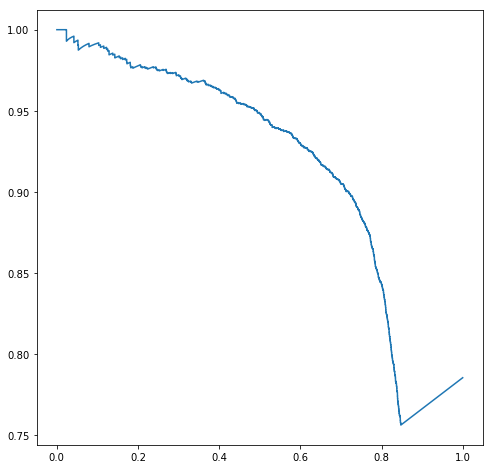

In [17]:
prec, rec, th = precision_recall_curve(need_to_detect.astype('float32'),
                                       detected_prob)
print('Precisions: {}'.format(prec))
print('Recalls: {}'.format(rec))
print('Thresholds: {}'.format(th))
print('Precision-recall auc: {}'.format(auc(rec, prec)))
plt.plot(rec, prec)
plt.show()

In [ ]:
plt.plot(th, rec[:-1])

In [26]:
main_img = imread('../../vehicle_detection/Test/2012-04-26-Muenchen-Tunnel_4K0G0110.JPG')
# main_img = imresize(main_img, (300 * 16, 300 * 16)).astype('float32')
# y_step = main_img.shape[0] // 16
# x_step = main_img.shape[1] // 16
# main_img = main_img[:, :, ::-1]
# # Zero-center by mean pixel
# main_img[:, :, 0] -= 103.939
# main_img[:, :, 1] -= 116.779
# main_img[:, :, 2] -= 123.68

In [27]:
inputs = []
for i in range(18):
    for j in range(19):
        x_min = i * 310
        x_max = x_min + 351
        x_max = min(main_img.shape[1], x_max)
        x_min = min(x_min, x_max - 351)
        y_min = j * 195
        y_max = y_min + 234
        y_max = min(main_img.shape[0], y_max)
        y_min = min(y_min, y_max - 234)
        test_img = imresize(main_img[y_min:y_max, x_min:x_max], (300, 300)).astype('float32')
        inputs.append(test_img)
inputs = preprocess_input(np.array(inputs))

In [ ]:
"""Some utils for SSD."""

import cv2
import numpy as np
import Polygon.Shapes as shapes


class BBoxUtility(object):
    """Utility class to do some stuff with bounding boxes and priors.

    # Arguments
        num_classes: Number of classes including background.
        priors: Priors and variances, numpy tensor of shape (num_priors, 9),
            priors[i] = [xc, yc, w, h, alpha, varxc, varyc, varw, varh].
        overlap_threshold: Threshold to assign box to a prior.

    # References
        https://arxiv.org/abs/1512.02325
    """
    def __init__(self, num_classes, priors=None, overlap_threshold=0.5):
        self.num_classes = num_classes
        self.priors = priors
        self.rect_priors = []
        for prior in priors:
            rect = shapes.Rectangle(prior[2], prior[3])
            rect.shift(prior[0] - prior[2]/2, -prior[1] - prior[3]/2)
            rect.rotate(prior[4])
            self.rect_priors.append((rect, rect.area()))
        self.num_priors = 0 if priors is None else len(priors)
        self.overlap_threshold = overlap_threshold

    def rects_iou(self, box):
        """Compute intersection over union for the box with all priors.

        # Arguments
            box: Box, numpy tensor of shape (5,).

        # Return
            iou: Intersection over union,
                numpy tensor of shape (num_priors).
        """
        # compute intersection
        box_rect = shapes.Rectangle(box[2], box[3])
        box_rect.shift(box[0] - box[2]/2, -box[1] - box[3]/2)
        box_rect.rotate(box[4])
        box_area = box_rect.area()
        iou = np.zeros(self.num_priors)
        for i, prior_rect in enumerate(self.rect_priors):
            inter_area = (box_rect & prior_rect[0]).area()
            union_area = box_area + prior_rect[1] - inter_area
            iou[i] = inter_area / union_area
        return iou

    def encode_box(self, box, return_iou=True):
        """Encode box for training, do it only for assigned priors.

        # Arguments
            box: Box, numpy tensor of shape (5,).
            return_iou: Whether to concat iou to encoded values.

        # Return
            encoded_box: Tensor with encoded box
                numpy tensor of shape (num_priors, 6 + int(return_iou)).
        """
        iou = self.rects_iou(box)
        encoded_box = np.zeros((self.num_priors, 6 + return_iou))
        assign_mask = iou > self.overlap_threshold
        if not assign_mask.any():
            assign_mask[iou.argmax()] = True
        if return_iou:
            encoded_box[:, -1][assign_mask] = iou[assign_mask]
        assigned_priors = self.priors[assign_mask]
        box_center = box[:2]
        box_wh = box[2:4]
        assigned_priors_center = assigned_priors[:, :2]
        assigned_priors_wh = assigned_priors[:, 2:4]
        # we encode variance
        encoded_box[:, :2][assign_mask] = box_center - assigned_priors_center
        encoded_box[:, :2][assign_mask] /= assigned_priors_wh
        encoded_box[:, :2][assign_mask] /= assigned_priors[:, -4:-2]
        encoded_box[:, 2:4][assign_mask] = np.log(box_wh /
                                                  assigned_priors_wh)
        encoded_box[:, 2:4][assign_mask] /= assigned_priors[:, -2:]
        # compute angle encodings
        # relative angle
        angle_change = (box[4] - assigned_priors[:, 4])
        # absolute angle
#         angle_change = box[4]
        encoded_box[:, 4][assign_mask] = np.cos(2 * angle_change)
        encoded_box[:, 5][assign_mask] = np.sin(2 * angle_change)
        return encoded_box.ravel()

    def assign_boxes(self, boxes, return_iou=False):
        """Assign boxes to priors for training.

        # Arguments
            boxes: Box, numpy tensor of shape (num_boxes, 5 + num_classes),
                num_classes without background.

        # Return
            assignment: Tensor with assigned boxes,
                numpy tensor of shape (num_boxes, 6 + num_classes + 9),
                priors in ground truth are fictitious,
                assignment[:, -9] has 1 if prior should be penalized
                    or in other words is assigned to some ground truth box,
                assignment[:, -8:] are all 0. See loss for more details.
        """
        assignment = np.zeros((self.num_priors, 6 + self.num_classes + 9))
        assignment[:, 6] = 1.0
        if len(boxes) == 0:
            return assignment
        encoded_boxes = np.apply_along_axis(self.encode_box, 1, boxes[:, :5])
        encoded_boxes = encoded_boxes.reshape(-1, self.num_priors, 7)
        best_iou = encoded_boxes[:, :, -1].max(axis=0)
        best_iou_idx = encoded_boxes[:, :, -1].argmax(axis=0)
        best_iou_mask = best_iou > 0
        best_iou_idx = best_iou_idx[best_iou_mask]
        assign_num = len(best_iou_idx)
        encoded_boxes = encoded_boxes[:, best_iou_mask, :]
        assignment[:, :6][best_iou_mask] = encoded_boxes[best_iou_idx,
                                                         np.arange(assign_num),
                                                         :-1]
        assignment[:, 6][best_iou_mask] = 0
        assignment[:, 7:-9][best_iou_mask] = boxes[best_iou_idx, 5:]
        assignment[:, -9][best_iou_mask] = 1
        if return_iou:
            return assignment, best_iou[best_iou_mask]
        return assignment

    def decode_boxes(self, mbox_loc, mbox_priorbox, variances):
        """Convert bboxes from local predictions to shifted priors.

        # Arguments
            mbox_loc: Numpy array of predicted locations.
            mbox_priorbox: Numpy array of prior boxes.
            variances: Numpy array of variances.

        # Return
            decode_bbox: Shifted priors.
        """
        prior_width = mbox_priorbox[:, 2]
        prior_height = mbox_priorbox[:, 3]
        prior_center_x = mbox_priorbox[:, 0]
        prior_center_y = mbox_priorbox[:, 1]
        prior_angle = mbox_priorbox[:, 4]
        # decode coordinates
        decode_bbox_center_x = mbox_loc[:, 0] * prior_width * variances[:, 0]
        decode_bbox_center_x += prior_center_x
        decode_bbox_center_y = mbox_loc[:, 1] * prior_height * variances[:, 1]
        decode_bbox_center_y += prior_center_y
        decode_bbox_width = np.exp(mbox_loc[:, 2] * variances[:, 2])
        decode_bbox_width *= prior_width
        decode_bbox_height = np.exp(mbox_loc[:, 3] * variances[:, 3])
        decode_bbox_height *= prior_height
        # decode angle
        decode_bbox_angle = (np.arccos(mbox_loc[:, 4]) / 2)
        decode_bbox_angle[mbox_loc[:, 5] < 0] -= np.pi
        decode_bbox_angle[mbox_loc[:, 5] < 0] *= -1
        # relative_angle
        decode_bbox_angle += prior_angle
        decode_bbox_angle[decode_bbox_angle > np.pi] -= np.pi
        decode_bbox_angle[decode_bbox_angle < 0] += np.pi
        decode_bbox = np.concatenate((decode_bbox_center_x[:, None],
                                      decode_bbox_center_y[:, None],
                                      decode_bbox_width[:, None],
                                      decode_bbox_height[:, None],
                                      decode_bbox_angle[:, None]), axis=-1)
        return decode_bbox

    def detection_out(self, predictions, background_label_id=0, keep_top_k=200,
                      nms_thresh=0.4, confidence_threshold=0.5):
        """Do non maximum suppression (nms) on prediction results.

        # Arguments
            predictions: Numpy array of predicted values.
            num_classes: Number of classes for prediction.
            background_label_id: Label of background class.
            keep_top_k: Number of total bboxes to be kept per image
                after nms step.
            nms_thresh: Nms threshold.
            confidence_threshold: Only consider detections,
                whose confidences are larger than a threshold.

        # Return
            results: List of predictions for every picture. Each prediction is:
                [label, confidence, xmin, ymin, xmax, ymax]
        """
        mbox_loc = predictions[:, :, :6]
        variances = predictions[:, :, -4:]
        mbox_priorbox = predictions[:, :, -9:-4]
        mbox_conf = predictions[:, :, 6:-9]
        results = []
        for i in range(len(mbox_loc)):
            results.append([])
#             decode_bbox = self.decode_boxes(mbox_loc[i],
#                                             mbox_priorbox[i], variances[i])
            for c in range(self.num_classes):
                if c == background_label_id:
                    continue
                c_confs = mbox_conf[i, :, c]
                c_confs_m = c_confs > confidence_threshold
                if len(c_confs[c_confs_m]) > 0:
                    boxes_to_process = self.decode_boxes(mbox_loc[i][c_confs_m],
                                                         mbox_priorbox[i][c_confs_m],
                                                         variances[i][c_confs_m])
#                     boxes_to_process = decode_bbox[c_confs_m]
                    confs_to_process = c_confs[c_confs_m]
                    idx = self.do_nms(boxes_to_process,
                                      confs_to_process, nms_thresh)
                    good_boxes = boxes_to_process[idx]
                    confs = mbox_conf[i, :, :][c_confs_m][idx]
                    c_pred = np.concatenate((good_boxes, confs), axis=1)
                    results[-1].extend(c_pred)
            if len(results[-1]) > 0:
                results[-1] = np.array(results[-1])
                if len(results[-1]) > keep_top_k:
                    argsort = np.argsort(results[-1][:, 5:].max(axis=1))
                    argsort = argsort[::-1]
                    results[-1] = results[-1][argsort]
                    results[-1] = results[-1][:keep_top_k]
            else:
                results[-1] = np.array(results[-1])
                results[-1] = results[-1].reshape(-1, 5 + self.num_classes)
        return results

    def rotated_iou(self, box1, box2):
        rect1 = shapes.Rectangle(box1[2], box1[3])
        rect1.shift(box1[0] - box1[2]/2, -box1[1] - box1[3]/2)
        rect1.rotate(box1[4])
        rect2 = shapes.Rectangle(box2[2], box2[3])
        rect2.shift(box2[0] - box2[2]/2, -box2[1] - box2[3]/2)
        rect2.rotate(box2[4])
        return (rect1 & rect2).area() / (rect1 | rect2).area()

    def do_nms(self, boxes, confs, nms_thresh):
        """Greedily select boxes.

        # Arguments
            boxes: Boxes coords, tensor of shape (num_boxes, 5)
            confs: Confidenses, tensor of shape (num_boxes)
            nms_thresh: Nms threshold.

        # Returns
            idx: Indexes of selected boxes, tensor of shape (num_selected)
        """
        idx = []
        c_sorted_idx = np.argsort(confs)[::-1]
        for c_idx in c_sorted_idx:
            box = boxes[c_idx]
            should_take = True
            for saved_i in idx:
                if (np.all(np.abs(box[:2] - boxes[saved_i, :2]) > 50)):
                    continue
                iou = self.rotated_iou(box, boxes[saved_i])
                if iou >= nms_thresh:
                    should_take = False
                    break
            if should_take:
                idx.append(c_idx)
        return np.array(idx)

    def draw_box_on_image(self, img, box, color=None, text=None):
        """Draw rotated box on image.

        # Arguments
            img: Image to draw on.
            box: Box to draw, numpy tensor of shape(5,) or (8,)
            color: Optional color of the box.
            text: Optional text to put in the box.

        # Return
            img: Image with box.
        """
        img_h, img_w, _ = img.shape
        x_main = box[2] * np.cos(box[4]) * img_w
        y_main = box[2] * np.sin(box[4]) * img_h
        h_new = np.linalg.norm([x_main, y_main])
        dir_mult = np.sign(y_main) if y_main != 0 else 1
        angle_new = np.arccos(x_main * dir_mult / h_new) / np.pi * 180
        x_main = box[3] * np.cos(box[4] + 0.5*np.pi) * img_w
        y_main = box[3] * np.sin(box[4] + 0.5*np.pi) * img_h
        w_new = np.linalg.norm([x_main, y_main])
        rect = ((box[0] * img_w, box[1] * img_h),
                (h_new, w_new),
                -angle_new)
        rect_p = cv2.boxPoints(rect)
        if color is None:
            color = box[5:] * 255
        for i in range(4):
            cv2.line(img, tuple(rect_p[i]),
                     tuple(rect_p[(i + 1) % 4]), color, thickness=2)
        if text:
            cv2.putText(img, text,
                        (int(rect[0][0]), int(rect[0][1])),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.3, [255, 255, 255], 1)
        return img

In [ ]:
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [35]:
# %%timeit
final_results = []
confs = []
for i in range(18):
    for j in range(19):
#         p_res = bbox_util.detection_out(preds[i*19 + j][None, :, :],
#                                         nms_thresh=0.1,
#                                         confidence_threshold=0.55)[0]
        p_res = results[i * 19 + j]
        if len(p_res) > 0:
            abs_box = rescale_preds(p_res[:, :5], i, j)
            final_results.extend(abs_box)
            confs.extend(p_res[:, -3:])
final_results = np.asarray(final_results)
confs = np.asarray(confs)
idxs = bbox_util.do_nms(final_results,
                        confs.max(axis=1), 0.1)
final_results = final_results[idxs]
final_confs = confs[idxs]

In [36]:
final_results.shape

(794, 5)

In [37]:
for i, res in enumerate(final_results):
    rect = res.copy()
    rect[-1] *= -180/np.pi
    rect = ((rect[0], rect[1]),
            (rect[2], rect[3]),
            rect[4])
    rect_p = cv2.boxPoints(rect)
    conf = final_confs[i]    
    color = [0, 0, 0]
    color[conf.argmax()] = 255
    for i in range(4):
        cv2.line(main_img, tuple(rect_p[i]),
                 tuple(rect_p[(i + 1) % 4]), color, thickness=2)
imsave('test_7.png', main_img)

In [34]:
def rescale_preds(boxes, x_num, y_num, new_img_w=351, new_img_h=234):
    x_main = boxes[:, 2] * np.cos(boxes[:, 4]) * new_img_w
    y_main = boxes[:, 2] * np.sin(boxes[:, 4]) * new_img_h
    h_new = np.linalg.norm([x_main, y_main], axis=0)
    dir_mult = np.sign(y_main)
    dir_mult[y_main == 0] = 1
    angle_new = np.arccos(x_main * dir_mult / h_new)
    x_main = boxes[:, 3] * np.cos(boxes[:, 4] + 0.5*np.pi) * new_img_w
    y_main = boxes[:, 3] * np.sin(boxes[:, 4] + 0.5*np.pi) * new_img_h
    w_new = np.linalg.norm([x_main, y_main], axis=0)
    boxes[:, 0] *= new_img_w
    boxes[:, 0] += x_num * 310
    boxes[:, 1] *= new_img_h
    boxes[:, 1] += y_num * 195
    boxes[:, 2] = h_new
    boxes[:, 3] = w_new
    boxes[:, 4] = angle_new
    return boxes

In [ ]:
res = []
b_confs = []
for i in range(18):
    for j in range(19):
        a = bbox_util.decode_boxes(preds[i*j, :, :6],
                                   preds[i*j, :, -9:-4],
                                   preds[i*j, :, -4:])
        b = rescale_preds(a, 351, 234, i, j)
        confs = preds[(i * 19) + j, :, 7:-9]
        max_confs = confs.max(axis=1)
        max_confs_mask = max_confs > 0.55
        res.extend(b[max_confs_mask])
        b_confs.extend(confs[max_confs_mask])
res = np.asarray(res)
b_confs = np.asarray(b_confs)

In [ ]:
idxs = bbox_util.do_nms(res, b_confs.max(axis=1), 0.1)

In [ ]:
idxs.shape

In [ ]:
for idx in idxs:
    rect = res[idx].copy()
    rect[-1] *= -180/np.pi
    rect = ((rect[0], rect[1]),
            (rect[2], rect[3]),
            rect[4])
    rect_p = cv2.boxPoints(rect)
    conf = b_confs[idx]    
    color = [0, 0, 0]
    color[conf.argmax()] = 255
    for i in range(4):
        cv2.line(main_img, tuple(rect_p[i]),
                 tuple(rect_p[(i + 1) % 4]), color, thickness=2)

In [31]:
# %%timeit
preds = model.predict(inputs, batch_size=18)
preds[:, :, 4] = np.clip(preds[:, :, 4], -1, 1)
results = bbox_util.detection_out(preds, nms_thresh=0.1, confidence_threshold=0.55)

1 loop, best of 3: 12.1 s per loop


In [ ]:
for i in range(18):
    for j in range(19):
        x_min = i * 310
        x_max = x_min + 351
        x_max = min(main_img.shape[1], x_max)
        x_min = min(x_min, x_max - 351)
        y_min = j * 195
        y_max = y_min + 234
        y_max = min(main_img.shape[0], y_max)
        y_min = min(y_min, y_max - 234)
        test_img = main_img[y_min:y_max, x_min:x_max]
        for res in results[i * 19 + j]:
            color = [0, 0, 0]
            color[res[-2:].argmax()] = 255
            bbox_util.draw_box_on_image(test_img, res[:5], color)

In [ ]:
imsave('test_6.png', main_img)

In [ ]:
# %%timeit
preds = model.predict_generator(prediction_gen(main_img), 8, workers=1)
preds[0, :, 4] = np.clip(preds[0, :, 4], -1, 1)
results = bbox_util.detection_out(preds, nms_thresh=0.4, confidence_threshold=0.5)

In [ ]:
train_get_dict = np.load('../../vehicle_detection/big_data/train_rot_new.npy')[()]

In [ ]:
keys = sorted(train_get_dict.keys())

In [ ]:
sorted(train_keys)[0]

In [ ]:
from scipy.misc import imsave
new_image = np.empty((234*16, 351*16, 3))
for im_num in range(256):
    inputs = []
    images = []
    img_path = path_prefix + sorted(val_keys)[im_num]
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())
    inputs = preprocess_input(np.array(inputs))
    preds = model.predict(inputs, batch_size=1)#, verbose=1)
    preds[:, :, 4] = np.clip(preds[0, :, 4], -1, 1)
    results = bbox_util.detection_out(preds, nms_thresh=0.1, confidence_threshold=0.55)
    for i, img in enumerate(images):
#         for res in train_get_dict[keys[im_num]]:
        for res in results[i]:
            color = [0, 0, 0]
#             color[res[-3:-1].argmax()] = 255
            color[res[-2:].argmax()] = 255
            img = bbox_util.draw_box_on_image(img, res[:5], color)
#             img = bbox_util.draw_box_on_image(img, res[:5], color)
    x_min = 351*(im_num % 16)
    x_max = 351*(im_num % 16 + 1)
    y_min = 234*(im_num // 16)
    y_max = 234*(im_num // 16 + 1)
    print(im_num, y_min, y_max, x_min, x_max)
    new_image[y_min:y_max, x_min:x_max, :] = img
imsave('test_5.png', new_image.astype('uint8'))

In [ ]:
from scipy.misc import imsave

In [ ]:
imsave('test.png', new_image.astype('uint8'))

In [ ]:
inputs = []
images = []
img_path = path_prefix + sorted(train_keys)[20000]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [ ]:
# %%timeit
preds = model.predict(inputs, batch_size=1, verbose=1)
preds[:, :, 4] = np.clip(preds[0, :, 4], -1, 1)
results = bbox_util.detection_out(preds, nms_thresh=0.1, confidence_threshold=0.5)

In [ ]:
for i, img in enumerate(images):
    for res in results[i]:
        color = [0, 0, 0]
        color[res[-2:].argmax()] = 255
        img = bbox_util.draw_box_on_image(img, res[:5], color)
    plt.imshow(img)
    plt.show()